In [2]:
!pip install -q -U transformers datasets accelerate peft bitsandbytes scikit-learn seaborn matplotlib requests

import requests
import os
import json
import gc
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AutoModelForCausalLM,
    Trainer, 
    TrainingArguments,
    BitsAndBytesConfig,
    EarlyStoppingCallback,
    pipeline,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

In [4]:
dialogue_path = "dailydialog/data/dialogues.json"

with open(dialogue_path, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

pairs = []

for dialogue in df["turns"]:
    for turn in dialogue:
        utt = turn["utterance"]

        try:
            intent = turn["dialogue_acts"]["binary"][0]["intent"]
        except:
            intent = None

        pairs.append({"utterance": utt, "intent": intent})

pairs_df = pd.DataFrame(pairs)
pairs_df.head()

,utterance,intent
0,"Say, Jim, how about going for a few beers afte...",directive
1,You know that is tempting but is really not go...,commissive
2,What do you mean? It will help us to relax.,question
3,Do you really think so? I don't. It will just ...,question
4,I guess you are right. But what shall we do? I...,question


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102979 entries, 0 to 102978
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   utterance  102979 non-null  object
 1   intent     102979 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB
None

=== First 5 Rows ===
                                           utterance      intent
0  Say, Jim, how about going for a few beers afte...   directive
1  You know that is tempting but is really not go...  commissive
2        What do you mean? It will help us to relax.    question
3  Do you really think so? I don't. It will just ...    question
4  I guess you are right. But what shall we do? I...    question

=== Missing Values ===
utterance    0
intent       0
dtype: int64

=== Intent Counts ===
intent
inform        46532
question      29428
directive     17295
commissive     9724
Name: count, dtype: int64


/tmp/ipykernel_48/2816621641.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")


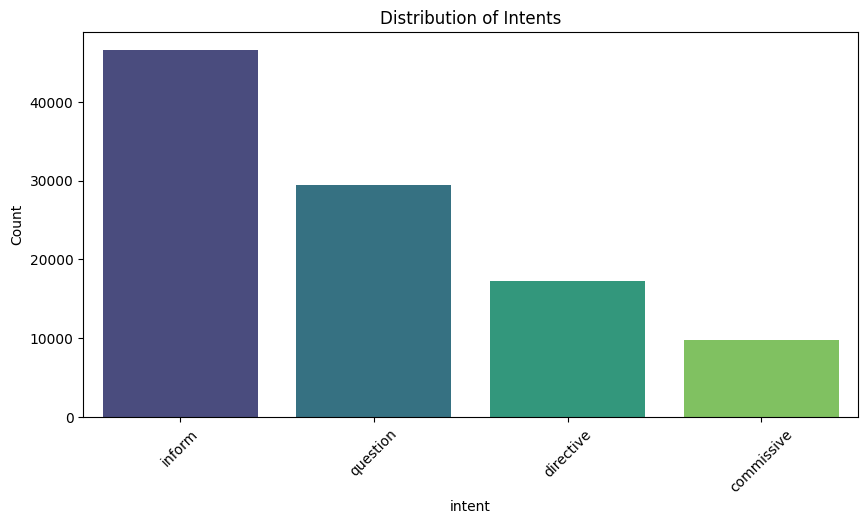

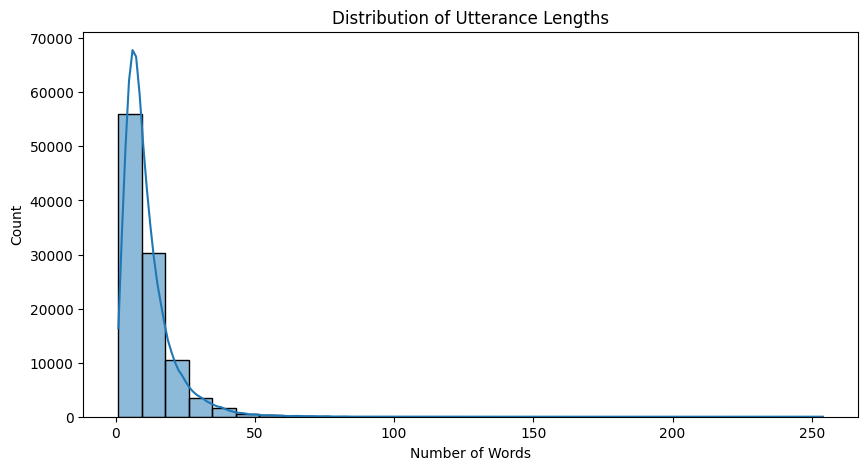


=== Top 5 Longest Utterances ===
                                               utterance  utt_len
38564  I have had an incredible boss, who was my dire...      254
29129  Jacob, you have the luxury of having a haircut...      224
57277  Jacob, you have the luxury of having a haircut...      224
73750  Not really. I did some research about Chinese ...      203
95497  Of course. I've loved writing since I was a ve...      179


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Dataset Info ===")
print(pairs_df.info())
print("\n=== First 5 Rows ===")
print(pairs_df.head())

print("\n=== Missing Values ===")
print(pairs_df.isna().sum())

intent_counts = pairs_df['intent'].value_counts()
print("\n=== Intent Counts ===")
print(intent_counts)

plt.figure(figsize=(10,5))
sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Distribution of Intents")
plt.show()

pairs_df['utt_len'] = pairs_df['utterance'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,5))
sns.histplot(pairs_df['utt_len'], bins=30, kde=True)
plt.xlabel("Number of Words")
plt.title("Distribution of Utterance Lengths")
plt.show()

print("\n=== Top 5 Longest Utterances ===")
print(pairs_df.sort_values('utt_len', ascending=False).head(5)[['utterance', 'utt_len']])


/tmp/ipykernel_48/2163089853.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


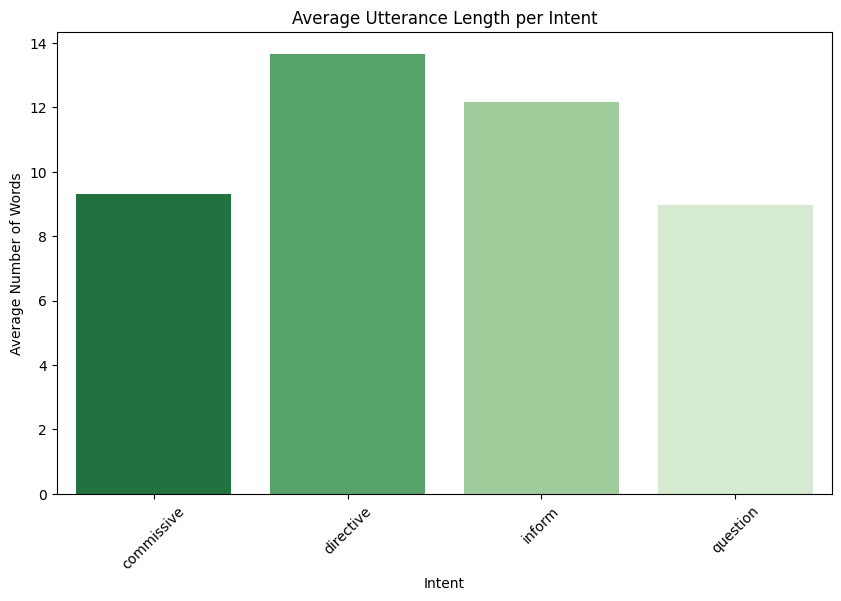

In [6]:
pairs_df['utterance_length'] = pairs_df['utterance'].apply(lambda x: len(x.split()))

avg_length_per_intent = pairs_df.groupby('intent')['utterance_length'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_length_per_intent,
    x='intent',
    y='utterance_length',
    palette='Greens_r'
)
plt.title('Average Utterance Length per Intent')
plt.xlabel('Intent')
plt.ylabel('Average Number of Words')
plt.xticks(rotation=45)
plt.show()

In [9]:
pairs_df.dropna(subset=['intent'], inplace=True)
pairs_df = pairs_df.reset_index(drop=True)

intent_counts = pairs_df['intent'].value_counts()
min_samples_needed = 3
valid_intents = intent_counts[intent_counts >= min_samples_needed].index
pairs_df = pairs_df[pairs_df['intent'].isin(valid_intents)]

unique_intents = sorted(pairs_df['intent'].unique())
intent_to_id = {intent: i for i, intent in enumerate(unique_intents)}
id_to_intent = {i: intent for intent, i in intent_to_id.items()}
pairs_df['label'] = pairs_df['intent'].map(intent_to_id)

RANDOM_SEED = 42
VAL_SIZE = 0.25
TEST_SIZE = 0.01

train_df, temp_df, train_labels, temp_labels = train_test_split(
    pairs_df,
    pairs_df['label'],
    test_size=(VAL_SIZE + TEST_SIZE),
    random_state=RANDOM_SEED,
    stratify=pairs_df['label']
)

val_df, test_df, val_labels, test_labels = train_test_split(
    temp_df,
    temp_df['label'],
    test_size=TEST_SIZE / (VAL_SIZE + TEST_SIZE),
    random_state=RANDOM_SEED,
    stratify=temp_df['label']
)

raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True))
})

NUM_LABELS = len(unique_intents)
MODEL_DIR = "model_results_intent"
os.makedirs(MODEL_DIR, exist_ok=True)

ENCODER_MODELS = {
    "DistilRoBERTa-base": "distilroberta-base",
    # "MiniLM-L12-v2": "sentence-transformers/all-MiniLM-L12-v2",
    # "DeBERTa-v3-base": "microsoft/deberta-v3-base"
}

DECODER_MODELS = {
    "Qwen3-4B-Instruct": "Qwen/Qwen3-4B-Instruct-2507",
    "Qwen2-7B-Instruct": "Qwen/Qwen2-7B-Instruct",
    "Ministral-8B-Instruct-v0.3": "mistralai/Ministral-8B-Instruct-2410",
}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    weighted_f1 = f1_score(labels, predictions, average="weighted")
    return {"weighted_macro_f1": weighted_f1}

def create_few_shot_prompt(utterance, examples, id_to_intent):
    system_prompt = (
        "You are an expert intent classifier. Your task is to identify the dialogue act "
        "of the user's and classify it into one of the following classes: "
        f"{', '.join(unique_intents)}. "
        "You must output only the single, lowercase intent word."
    )

    example_prompt = ""
    for utt, label_id in examples:
        intent = id_to_intent[label_id]
        example_prompt += f"Utterance: \"{utt}\"\nIntent: {intent}\n\n"

    user_prompt = f"Sentence: \"{utterance}\"\nIntent:"

    prompt = (
        f"<s>[INST] {system_prompt}\n\n"
        f"Here are a few examples to guide your classification:\n\n"
        f"{example_prompt}"
        f"{user_prompt} [/INST]"
    )
    return prompt

def get_few_shot_examples(train_dataset, num_examples_per_class=2):
    examples = []
    df_train = train_dataset.to_pandas()
    for intent_id in unique_intents:
        class_df = df_train[df_train['label'] == intent_to_id[intent_id]]
        num_to_sample = min(num_examples_per_class, len(class_df))
        sampled_examples = class_df.sample(n=num_to_sample, random_state=RANDOM_SEED)

        for _, row in sampled_examples.iterrows():
            examples.append((row['utterance'], row['label']))

    np.random.shuffle(examples)
    return examples

FEW_SHOT_EXAMPLES = [
    ("That's a good idea. I hear Mary and Sally often go there to play pingpong. Perhaps we can make a foursome with them.", intent_to_id['commissive']),
    ("All right, see you later.", intent_to_id['commissive']),

    ("Say, Jim, how about going for a few beers after dinner?", intent_to_id['directive']),
    ("I suggest a walk over to the gym where we can play singsong and meet some of our friends.", intent_to_id['directive']),

    ("Sounds great to me! If they are willing, we could ask them to go dancing with us. That is excellent exercise and fun, too.", intent_to_id['inform']),
    ("I will be all right soon. I was terrified when I watched them fall from the wire.", intent_to_id['inform']),

    ("What do you mean? It will help us to relax.", intent_to_id['question']),
    ("Can you do push-ups?", intent_to_id['question']),
]

np.random.shuffle(FEW_SHOT_EXAMPLES)

In [10]:
encoder_results = {}

for model_name, model_id in tqdm(ENCODER_MODELS.items(), desc="Encoder Fine-tuning"):
    print(f"\n--- Running Encoder Experiment: {model_name} (Fine-tuning with Early Stopping) ---")

    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

    def tokenize_function(examples):
        return tokenizer(examples["utterance"], truncation=True, max_length=128)

    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=['utterance', 'intent'])

    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=NUM_LABELS,
        id2label=id_to_intent,
        label2id=intent_to_id
    )

    training_args = TrainingArguments(
        output_dir=f"{MODEL_DIR}/{model_name}_finetune",
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="weighted_macro_f1",
        greater_is_better=True,
        push_to_hub=False,
        seed=RANDOM_SEED,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    test_results = trainer.evaluate(tokenized_datasets["test"])
    f1_score_val = test_results['eval_weighted_macro_f1']

    predictions = trainer.predict(tokenized_datasets["test"])
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    cm = confusion_matrix(labels, preds)
    misclassified_indices = np.where(labels != preds)[0]

    misclassified_df = raw_datasets['test'].select(misclassified_indices).to_pandas()
    misclassified_df['predicted_intent'] = [id_to_intent[p] for p in preds[misclassified_indices]]
    misclassified_df['true_intent'] = [id_to_intent[l] for l in labels[misclassified_indices]]

    encoder_results[model_name] = {
        "F1_Weighted_Macro": f1_score_val,
        "Confusion_Matrix": cm,
        "Misclassified_Examples": misclassified_df[['utterance', 'true_intent', 'predicted_intent']]
    }

    print(f"Test F1 Weighted Macro: {f1_score_val:.4f}")

Encoder Fine-tuning:   0%|          | 0/1 [00:00<?, ?it/s]


--- Running Encoder Experiment: DistilRoBERTa-base (Fine-tuning with Early Stopping) ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/76204 [00:00<?, ? examples/s]

Map:   0%|          | 0/25745 [00:00<?, ? examples/s]

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/2538655501.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Weighted Macro F1
1,0.474300,0.492369,0.802756
2,0.457400,0.489758,0.810695
3,0.383100,0.492689,0.810592


Test F1 Weighted Macro: 0.8252


In [ ]:
decoder_results = {}

for model_name, model_id in tqdm(DECODER_MODELS.items(), desc="Decoder Few-Shot No Fine-tune"):

    exp_name_a = f"{model_name}_FewShot_NoFinetune"
    print(f"\n--- Running Decoder Experiment: {exp_name_a} ---")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
        device_map="auto"
    )

    def few_shot_inference(data, model, tokenizer):
        predicted_labels = []
        true_labels = []
        for row in tqdm(data, desc=f"Inference: {model_name}"):
            true_labels.append(row['label'])

            prompt = create_few_shot_prompt(row['utterance'], FEW_SHOT_EXAMPLES, id_to_intent)

            input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
            output_tokens = model.generate(
                input_ids,
                max_new_tokens=3,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )

            response = tokenizer.decode(output_tokens[0][input_ids.shape[-1]:], skip_special_tokens=True).strip().lower()

            predicted_intent = None
            for intent in unique_intents:
                if intent in response:
                    predicted_intent = intent
                    break

            predicted_label = intent_to_id.get(predicted_intent, np.random.choice(list(intent_to_id.values())))

            predicted_labels.append(predicted_label)
        return true_labels, predicted_labels

    true_labels_a, predicted_labels_a = few_shot_inference(raw_datasets["test"], model, tokenizer)

    f1_score_a = f1_score(true_labels_a, predicted_labels_a, average="weighted")
    cm_a = confusion_matrix(true_labels_a, predicted_labels_a)

    misclassified_a_indices = np.where(np.array(true_labels_a) != np.array(predicted_labels_a))[0]
    misclassified_a_df = raw_datasets['test'].select(misclassified_a_indices).to_pandas()
    misclassified_a_df['predicted_intent'] = [id_to_intent[p] for p in np.array(predicted_labels_a)[misclassified_a_indices]]
    misclassified_a_df['true_intent'] = [id_to_intent[l] for l in np.array(true_labels_a)[misclassified_a_indices]]

    decoder_results[exp_name_a] = {
        "F1_Weighted_Macro": f1_score_a,
        "Confusion_Matrix": cm_a,
        "Misclassified_Examples": misclassified_a_df[['utterance', 'true_intent', 'predicted_intent']]
    }
    print(f"Test F1 Weighted Macro (No Fine-tune): {f1_score_a:.4f}")

In [17]:
all_results = {}

for k, v in encoder_results.items():
    all_results[k] = v['F1_Weighted_Macro']
# for k, v in decoder_results.items():
#     all_results[k] = v['F1_Weighted_Macro']

results_df = (
    pd.DataFrame(all_results.items(), columns=['Experiment', 'F1_Weighted_Macro'])
    .sort_values(by='F1_Weighted_Macro', ascending=False)
    .reset_index(drop=True)
)

print("## Summary of All Experiment Results (F1 Weighted Macro)")
for _, row in results_df.iterrows():
    print(f"- {row['Experiment']}: {row['F1_Weighted_Macro']:.4f}")


def plot_confusion_matrix(cm, labels, title, filename):
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f'Confusion Matrix for {title} (Percentage)')
    plt.ylabel('True Intent')
    plt.xlabel('Predicted Intent')
    plt.savefig(filename)
    plt.close()


def print_misclassified_lines(df, title, max_rows=5):
    print(f"\n### {title}\n")
    df = df.head(max_rows)
    for i, row in df.iterrows():
        print(f"Example {i+1}:")
        print(f"Utterance        : {row['utterance']}")
        print(f"True Intent      : {row['true_intent']}")
        print(f"Predicted Intent : {row['predicted_intent']}")
        print("-" * 60)


print("\n## Confusion Matrix Visualization and Misclassified Examples ##")

best_model_name = results_df['Experiment'].iloc[0]
print(f"\nBest Model: {best_model_name}")

if best_model_name in encoder_results:
    best_cm = encoder_results[best_model_name]['Confusion_Matrix']
    best_misclassified = encoder_results[best_model_name]['Misclassified_Examples']
# else:
#     best_cm = decoder_results[best_model_name]['Confusion_Matrix']
#     best_misclassified = decoder_results[best_model_name]['Misclassified_Examples']

# best_cm = decoder_results[best_model_name]['Confusion_Matrix']
# best_misclassified = decoder_results[best_model_name]['Misclassified_Examples']

plot_confusion_matrix(
    best_cm,
    unique_intents,
    f"{best_model_name}",
    f"{best_model_name}_CM.png"
)
print(f"Saved confusion matrix: {best_model_name}_CM.png")

print_misclassified_lines(
    best_misclassified,
    f"Misclassified Examples for Best Model: {best_model_name}",
    max_rows=5
)

decoder_base = list(DECODER_MODELS.keys())[0]
lora_model_name = f"{decoder_base}_FewShot_LoRA"
lora_cm = decoder_results[lora_model_name]['Confusion_Matrix']
lora_misclassified = decoder_results[lora_model_name]['Misclassified_Examples']

plot_confusion_matrix(
    lora_cm,
    unique_intents,
    f"{decoder_base} (Few-Shot, LoRA)",
    f"{lora_model_name}_CM.png"
)
print(f"Saved confusion matrix: {lora_model_name}_CM.png")

print_misclassified_lines(
    lora_misclassified,
    f"Misclassified Examples for LoRA Model: {lora_model_name}",
    max_rows=5
)


## Summary of All Experiment Results (F1 Weighted Macro)
- DistilRoBERTa-base: 0.8252

## Confusion Matrix Visualization and Misclassified Examples ##

Best Model: DistilRoBERTa-base
Saved confusion matrix: DistilRoBERTa-base_CM.png

### Misclassified Examples for Best Model: DistilRoBERTa-base

Example 1:
Utterance        : Okay, I'm coming downstairs now.
True Intent      : inform
Predicted Intent : commissive
------------------------------------------------------------
Example 2:
Utterance        : Fred, we're gonna have a meeting after half an hour. Have you got it?
True Intent      : question
Predicted Intent : directive
------------------------------------------------------------
Example 3:
Utterance        : I do want to send it airmail, yes.
True Intent      : inform
Predicted Intent : directive
------------------------------------------------------------
Example 4:
Utterance        : Who has a crush? !
True Intent      : inform
Predicted Intent : question
---------------------

NameError: name 'decoder_results' is not defined

In [19]:
# del model
# del tokenizer
# del outputs
# import gc

gc.collect()

torch.cuda.empty_cache()

print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2740 MiB |  15781 MiB | 129982 MiB | 127242 MiB |
|       from large pool |   2661 MiB |  15608 MiB | 129637 MiB | 126976 MiB |
|       from small pool |     79 MiB |    213 MiB |    345 MiB |    266 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   2740 MiB |  15781 MiB | 129982 MiB | 127242 MiB |
|       from large pool |   2661 MiB |  15608 MiB | 129637 MiB |